## Training CNN on CIFAR10 Dataset [1]

### CIFAR10 dataset
![CIFAR10](../pics/cifar10.png)

## Components of a DL Project

### Dataloader and Transformers


To make data loading simple, we would use the torchvision package created as part of PyTorch which has data loaders for standard datasets such as ImageNet, CIFAR10, MNIST.


In [1]:
#a Tensor library with GPU support
import torch

#Datasets, Transforms and Models specific to Computer Vision
import torchvision
import torchvision.transforms as transforms

####train data
#Compose transforms (applies data transformation and augmentation) prior to feeding to training
train_transform = transforms.Compose(
    [#transforms.RandomResizedCrop(224),
     transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.Resize(224),
     #transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#inbuilt dataset class for reading CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=train_transform)
print("train : " + str(len(trainset)) + ' images')

train_samples = 'all'
sampler = None

if train_samples != 'all':
    # collect the indices for each class
    indices = {}
    
    for i, (data, label) in enumerate(trainset):
        if label in indices:
            indices[label].append(i)
        else:
            indices[label] = []
            indices[label].append(i)
    
    print(len(indices[0]))
    final_indices = []
    for i in range(10):
        final_indices += indices[i][:train_samples]
    
    print(len(final_indices))
    subset_sampler = torch.utils.data.SubsetRandomSampler(indices=final_indices)
    sampler = subset_sampler

#dataloader for Batching, shuffling and loading data in parallel
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          num_workers=2, sampler=sampler)

print("train : " + str(len(trainloader) * 4) + ' images')

####test data
testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=False, transform=test_transform)
print("test : " + str(len(testset)) + ' images')

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

print(("image size : ", testset[0][0].size()))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
train : 50000 images
train : 1564 images
test : 10000 images
('image size : ', torch.Size([3, 224, 224]))


#### Visualizing the dataset images

GroundTruth:    cat  ship  ship plane


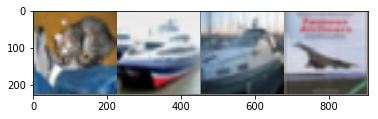

In [2]:
#plotting and visualization library
import matplotlib.pyplot as plt
#Display on the notebook
%matplotlib inline 
plt.ion() #Turn interactive mode on.

#scientific computing library for Python
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Options

In [3]:
class options():
    def __init__(self):
        self.pretrained = True
        self.use_gpu = True
        self.freeze_non_fc = False

opts = options()

# ResNet18 network


In [4]:
#a neural networks library integrated with autograd functionality
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class Net(nn.Module):
    
    #define the learnable paramters by calling the respective modules (nn.Conv2d, nn.MaxPool2d etc.)
    def __init__(self, pretrained):
        super(Net, self).__init__()
        
        #features
        #self.features = models.alexnet(pretrained=pretrained).features
        self.model = models.resnet18(pretrained=pretrained)
        
        #classifier
        self.model.fc = nn.Sequential(nn.Dropout(0.3), 
                                        nn.Linear(512, 10))
        
#                                         nn.Dropout(0.3),
#                                         nn.ReLU(),
#                                         nn.Linear(512, 10))

    
    #defining the structure of the network
    def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.shape[0], -1)
#         x = self.classifier(x)
        x = self.model(x)
        return x

net = Net(pretrained=opts.pretrained)

#Printing the network architecture
print(net)


Net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [5]:
#Printing the parameter values
params = list(net.parameters())
for name, param in net.named_parameters():
    if 'fc' not in name and opts.freeze_non_fc:
        print(name, ' frozen')
        param.requires_grad = False
    print(name, param.shape) 

model.conv1.weight torch.Size([64, 3, 7, 7])
model.bn1.weight torch.Size([64])
model.bn1.bias torch.Size([64])
model.layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
model.layer1.0.bn1.weight torch.Size([64])
model.layer1.0.bn1.bias torch.Size([64])
model.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
model.layer1.0.bn2.weight torch.Size([64])
model.layer1.0.bn2.bias torch.Size([64])
model.layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
model.layer1.1.bn1.weight torch.Size([64])
model.layer1.1.bn1.bias torch.Size([64])
model.layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
model.layer1.1.bn2.weight torch.Size([64])
model.layer1.1.bn2.bias torch.Size([64])
model.layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
model.layer2.0.bn1.weight torch.Size([128])
model.layer2.0.bn1.bias torch.Size([128])
model.layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
model.layer2.0.bn2.weight torch.Size([128])
model.layer2.0.bn2.bias torch.Size([128])
model.layer2.0.downsample.0.weight torch.Size([1

#### Forward Pass

In [6]:
input = torch.randn(1, 3, 224, 224)
out = net(input)
print(out)

tensor([[ 1.0019, -0.0905, -0.2317, -0.3285, -0.2088,  0.1408,  0.0216, -0.9856,
         -1.2456,  0.3394]], grad_fn=<ThAddmmBackward>)


#### Backward Pass

In [7]:
net.zero_grad()
out.backward(torch.randn(1, 10))

#### Loss Function
In this example, we will use Classification Cross-Entropy loss and SGD with momentum.<br>
Cross Entropy loss is given as:- $L=-\sum_i y_i \log(p_i)$ and $p_i=\frac{\exp^{x_i}}{\sum_k \exp^{x_k}}$

There are many other loss functions such as MSELoss, L1Loss etc. Visit [here](http://pytorch.org/docs/master/nn.html#loss-functions) for other loss functions.

In [8]:
criterion = nn.CrossEntropyLoss()
print(criterion)

CrossEntropyLoss()



#### Stochastic Gradient Descent (SGD)
$$w_{n+1} = w_{n} - \eta \triangle$$
$$\triangle = 0.9\triangle + \frac{\partial L}{\partial w}$$

Although SGD is the most popular and basic optimizer that one should first try. There are many adaptive optimizers like Adagrad,Adadelta RMSProp and many more. Visit [here](http://pytorch.org/docs/master/optim.html) for other examples.

In [9]:
#an optimization package with standard optimization methods such as SGD, RMSProp, LBFGS, Adam etc.
import torch.optim as optim
params = [param for param in net.parameters()
                 if param.requires_grad]
print(len(params))
optimizer = optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=5e-4)

62


#### Training in mini-batches

In [10]:
########################################################################
# Train the network
# ^^^^^^^^^^^^^^^^^^^^

def train(epoch, trainloader, optimizer, criterion):
    running_loss = 0.0
    
    net.train()
    
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if opts.use_gpu and torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # addup loss
        running_loss += loss.item()

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    return running_loss / (len(trainloader))   

#### Forward Pass over the trained network

Predicted:  truck plane plane truck


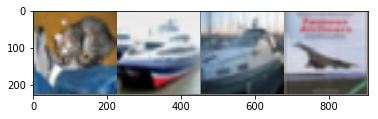

In [11]:
outputs = net(images)
_, predicted = torch.max(outputs.data, 1)


imshow(torchvision.utils.make_grid(images))
print('Predicted: ', ' '.join(['%5s' % classes[predicted[j]] for j in range(4)]))

### Test Accuracy 

In [12]:
########################################################################
# Let us look at how the network performs on the test dataset.

def test(testloader, model):
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in tqdm(testloader):
            # get the inputs
            inputs, labels = data
            if  opts.use_gpu and torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # addup loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%, loss = %f' % (
                                    100 * correct / total, running_loss / len(testloader)))
    return running_loss / len(testloader)


### Class-wise accuracy


In [13]:

def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    model.eval()
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if opts.use_gpu and torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))


In [14]:
import os
from tqdm import tqdm_notebook as tqdm
print('Start Training')
if not os.path.exists('./models'):
    os.mkdir('./models')

training_losses = []
testing_losses = []
num_epochs = 10

if  opts.use_gpu and torch.cuda.is_available():
    net = net.cuda()

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train_loss = train(epoch, trainloader, optimizer, criterion)
    test_loss = test(testloader, net)
    classwise_test(testloader, net)
    torch.save(net.state_dict(), './models/model-'+str(epoch)+'.pth')
    
    training_losses.append(train_loss)
    testing_losses.append(test_loss)

print('Finished Training')



Start Training
epoch  1



epoch 1 training loss: 1.726



Accuracy of the network on the 10000 test images: 69 %, loss = 1.130451



Accuracy of plane : 70 %
Accuracy of   car : 80 %
Accuracy of  bird : 50 %
Accuracy of   cat : 53 %
Accuracy of  deer : 57 %
Accuracy of   dog : 72 %
Accuracy of  frog : 80 %
Accuracy of horse : 70 %
Accuracy of  ship : 79 %
Accuracy of truck : 84 %
epoch  2



epoch 2 training loss: 0.961



Accuracy of the network on the 10000 test images: 80 %, loss = 0.713934



Accuracy of plane : 84 %
Accuracy of   car : 89 %
Accuracy of  bird : 65 %
Accuracy of   cat : 66 %
Accuracy of  deer : 73 %
Accuracy of   dog : 78 %
Accuracy of  frog : 86 %
Accuracy of horse : 78 %
Accuracy of  ship : 88 %
Accuracy of truck : 90 %
epoch  3



epoch 3 training loss: 0.679



Accuracy of the network on the 10000 test images: 84 %, loss = 0.545126



Accuracy of plane : 86 %
Accuracy of   car : 90 %
Accuracy of  bird : 73 %
Accuracy of   cat : 71 %
Accuracy of  deer : 80 %
Accuracy of   dog : 81 %
Accuracy of  frog : 89 %
Accuracy of horse : 82 %
Accuracy of  ship : 90 %
Accuracy of truck : 92 %
epoch  4



epoch 4 training loss: 0.541



Accuracy of the network on the 10000 test images: 86 %, loss = 0.454198



Accuracy of plane : 89 %
Accuracy of   car : 92 %
Accuracy of  bird : 80 %
Accuracy of   cat : 75 %
Accuracy of  deer : 84 %
Accuracy of   dog : 83 %
Accuracy of  frog : 92 %
Accuracy of horse : 85 %
Accuracy of  ship : 91 %
Accuracy of truck : 93 %
epoch  5



epoch 5 training loss: 0.457



Accuracy of the network on the 10000 test images: 88 %, loss = 0.394330



Accuracy of plane : 89 %
Accuracy of   car : 93 %
Accuracy of  bird : 82 %
Accuracy of   cat : 77 %
Accuracy of  deer : 86 %
Accuracy of   dog : 85 %
Accuracy of  frog : 93 %
Accuracy of horse : 87 %
Accuracy of  ship : 92 %
Accuracy of truck : 94 %
epoch  6



epoch 6 training loss: 0.401



Accuracy of the network on the 10000 test images: 89 %, loss = 0.351700



Accuracy of plane : 92 %
Accuracy of   car : 93 %
Accuracy of  bird : 84 %
Accuracy of   cat : 77 %
Accuracy of  deer : 88 %
Accuracy of   dog : 86 %
Accuracy of  frog : 94 %
Accuracy of horse : 89 %
Accuracy of  ship : 93 %
Accuracy of truck : 94 %
epoch  7



epoch 7 training loss: 0.358



Accuracy of the network on the 10000 test images: 90 %, loss = 0.323950



Accuracy of plane : 92 %
Accuracy of   car : 94 %
Accuracy of  bird : 85 %
Accuracy of   cat : 78 %
Accuracy of  deer : 90 %
Accuracy of   dog : 86 %
Accuracy of  frog : 94 %
Accuracy of horse : 89 %
Accuracy of  ship : 93 %
Accuracy of truck : 94 %
epoch  8



epoch 8 training loss: 0.327



Accuracy of the network on the 10000 test images: 90 %, loss = 0.304116



Accuracy of plane : 92 %
Accuracy of   car : 94 %
Accuracy of  bird : 87 %
Accuracy of   cat : 79 %
Accuracy of  deer : 90 %
Accuracy of   dog : 86 %
Accuracy of  frog : 94 %
Accuracy of horse : 90 %
Accuracy of  ship : 93 %
Accuracy of truck : 94 %
epoch  9



epoch 9 training loss: 0.301



Accuracy of the network on the 10000 test images: 90 %, loss = 0.284590



Accuracy of plane : 92 %
Accuracy of   car : 94 %
Accuracy of  bird : 87 %
Accuracy of   cat : 79 %
Accuracy of  deer : 91 %
Accuracy of   dog : 87 %
Accuracy of  frog : 95 %
Accuracy of horse : 91 %
Accuracy of  ship : 94 %
Accuracy of truck : 94 %
epoch  10



epoch 10 training loss: 0.281



Accuracy of the network on the 10000 test images: 91 %, loss = 0.270335



Accuracy of plane : 93 %
Accuracy of   car : 95 %
Accuracy of  bird : 88 %
Accuracy of   cat : 80 %
Accuracy of  deer : 92 %
Accuracy of   dog : 88 %
Accuracy of  frog : 95 %
Accuracy of horse : 92 %
Accuracy of  ship : 93 %
Accuracy of truck : 94 %
Finished Training


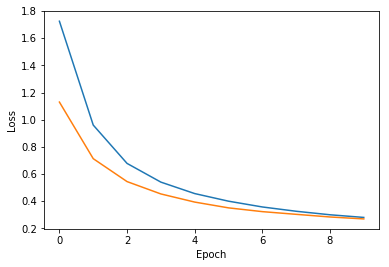

In [15]:
#Plotting the training graph
plt.plot(range(len(training_losses)), training_losses, label="train")
plt.plot(range(len(testing_losses)), testing_losses, label="test")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()